In [1]:
import time
import datetime
import numpy as np
import pandas as pd
import datatable as dt
pd.set_option("display.max_columns", None, "display.max_rows", None)

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, LSTM, Concatenate, Add, LeakyReLU, Reshape, Flatten, TimeDistributed



from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

2022-01-02 04:50:12.876053: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
%%time
train = dt.fread('../input/g-research-crypto-forecasting/train.csv').to_pandas()

CPU times: user 12.2 s, sys: 3.15 s, total: 15.4 s
Wall time: 58.5 s


In [3]:
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df

def preprocessing(df, batch_size=512):
    df = df.set_index('timestamp')
    df = df.sort_index()
    global ind
    ind = df.index.unique()
    df = df.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
    del ind
    df = df.reset_index()
    df = df.sort_values(by=['timestamp', 'Asset_ID'])
    df['date'] = pd.to_datetime(df.timestamp, unit='s')
    df.drop(['timestamp'], axis=1, inplace=True)
    print("="*30, ">", "Stage 1 finished")
    
    df['min_'] = (pd.DatetimeIndex(df['date']).minute.astype('uint8')/60).astype('float16')
    df['hr_'] = (pd.DatetimeIndex(df['date']).hour.astype('uint8')/24).astype('float16')
    df['day_'] = (pd.DatetimeIndex(df['date']).day.astype('uint8')/30).astype('float16')
    df['day_in_week'] = pd.DatetimeIndex(df['date']).day_of_week.astype('uint8')
    df['week'] = (pd.DatetimeIndex(df['date']).week.astype('uint8')/54).astype('float16')
    df['is_month_start'] = pd.DatetimeIndex(df['date']).is_month_start.astype(int).astype('uint8')
    df['is_month_end'] = pd.DatetimeIndex(df['date']).is_month_end.astype(int).astype('uint8')
    df['is_quarter_start'] = pd.DatetimeIndex(df['date']).is_quarter_start.astype(int).astype('uint8')
    df['is_quarter_end'] = pd.DatetimeIndex(df['date']).is_quarter_end.astype(int).astype('uint8')
    df['is_year_start'] = pd.DatetimeIndex(df['date']).is_year_start.astype(int).astype('uint8')
    df['is_year_end'] = pd.DatetimeIndex(df['date']).is_year_end.astype(int).astype('uint8')
    
    float_cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'min_', 'hr_', 'day_', 'week']
    df[float_cols] = df[float_cols].astype('float16')
    time.sleep(10)
    print("="*30, ">", "Stage 2 finished")
    
    ohe_asset = OneHotEncoder(handle_unknown='ignore')
    ohe_asset.fit(df[['Asset_ID']])
    ohe_day_in_week = OneHotEncoder(handle_unknown='ignore')
    ohe_day_in_week.fit(df[['day_in_week']])  
    df = pd.concat([df, pd.DataFrame(ohe_asset.transform(df[['Asset_ID']]).toarray(), columns = ohe_asset.get_feature_names()).astype('uint8')], axis=1)
    time.sleep(10)
    df = pd.concat([df, pd.DataFrame(ohe_day_in_week.transform(df[['day_in_week']]).toarray(), columns = ohe_day_in_week.get_feature_names()).astype('uint8')], axis=1)
    time.sleep(10)
    df = df.drop(['Asset_ID', 'day_in_week'], axis=1)
    print("="*30, ">", "Stage 3 finished") 
    
    df = df.fillna(-0.999)
    time.sleep(10)
    df = df.replace(-np.inf, -0.999)
    time.sleep(10)
    df = df.replace(np.inf, 100000)
    time.sleep(10)
    df.iloc[:, :7] = np.log1p(df.iloc[:, :7]).astype('float16')
    print("="*30, ">", "Stage 4 finished")
    
    train_df = df[(df['date'] < datetime.datetime(2021, 8, 15))]
    valid_df = df[df['date'] >= datetime.datetime(2021, 8, 15)]
    del df
    time.sleep(10)
    train_df.drop(['date'], axis=1, inplace=True)
    valid_df.drop(['date'], axis=1, inplace=True)
    print("="*30, ">", "Stage 5 finished")
    
    y_train = train_df['Target'].values
    X_train = train_df.drop('Target', axis=1)
    del train_df
    time.sleep(10)
    y_valid = valid_df['Target'].values
    X_valid = valid_df.drop('Target', axis=1)
    del valid_df
    time.sleep(10)
    print("="*30, ">", "Stage 6 finished")
    
    X_train = X_train.values.reshape(-1, 14, X_train.shape[-1])
    y_train = y_train.reshape(-1, 14,)
    X_valid = X_valid.values.reshape(-1, 14, X_valid.shape[-1])
    y_valid = y_valid.reshape(-1, 14,)
    print("="*30, ">", "Stage 7 finished")
    
    replace_na = np.float16(np.log1p(-0.999))
    X_train = np.nan_to_num(X_train, nan=replace_na)
    time.sleep(10)
    y_train = np.nan_to_num(y_train, nan=replace_na)
    X_valid = np.nan_to_num(X_valid, nan=replace_na)
    time.sleep(10)
    y_valid = np.nan_to_num(y_valid, nan=replace_na)
    print("="*30, ">", "Stage 8 finished")
    
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).cache().prefetch(AUTOTUNE)
    valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size).cache().prefetch(AUTOTUNE)
    del X_train, y_train, X_valid, y_valid
    print("="*30, ">", "Stage 9 finished")
    
    return train_ds, valid_ds

In [4]:
BATCH_SIZE = 512
EPOCHS = 30
LR = 1e-3
train_ds, valid_ds = preprocessing(train, batch_size=BATCH_SIZE)

============================== > Stage 1 finished


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


============================== > Stage 2 finished
============================== > Stage 3 finished
============================== > Stage 4 finished
============================== > Stage 5 finished
============================== > Stage 6 finished
============================== > Stage 7 finished
============================== > Stage 8 finished


2022-01-02 04:55:37.012832: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-02 04:55:37.017659: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-02 04:55:37.069930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 04:55:37.070660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-02 04:55:37.070733: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-02 04:55:37.099655: I tensorflow/stream_executor/platform/def

============================== > Stage 9 finished


2022-01-02 04:55:40.817776: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2025514456 exceeds 10% of free system memory.


In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * BATCH_SIZE
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 512


In [6]:
def embedding_block(inputs, list_layer_units):
    x = TimeDistributed(Dense(units=list_layer_units[0]))(inputs)
    x = LeakyReLU(alpha=0.3)(x)
    for units in list_layer_units[1:]:
        x = TimeDistributed(Dense(units=units))(x)
        x = LeakyReLU(alpha=0.3)(x)
    return x

In [7]:
def dense_block(inputs, list_layer_units):
    x = Dense(units=list_layer_units[0])(inputs)
    x = LeakyReLU(alpha=0.3)(x)
    for units in list_layer_units[1:]:
        x = Dense(units=units)(x)
        x = LeakyReLU(alpha=0.3)(x)
    return x

In [8]:
def GRU_block(inputs, list_layer_units):
    x = GRU(units=list_layer_units[0], return_sequences=True)(inputs)
    for units in list_layer_units[1:]:
        x = GRU(units=units, return_sequences=True)(x)
    
    return x

In [9]:
def my_model():
    inputs = Input(shape=(14, 38))
    # embedding block
    embeddings = embedding_block(inputs, [256, 128, 128])
    # GRUs block
    grus = GRU_block(embeddings, [756, 512, 256])
    # concat
    concat = Concatenate()([embeddings, grus])
    # Dense layers
    post_embeddings = dense_block(concat, [128, 128])
    # output
    #dense = Dense(units=128)(post_embeddings)
    outputs = Dense(units=1)(post_embeddings)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
model = my_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 38)]     0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 14, 256)      9984        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 256)      0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 14, 128)      32896       leaky_re_lu[0][0]                
______________________________________________________________________________________________

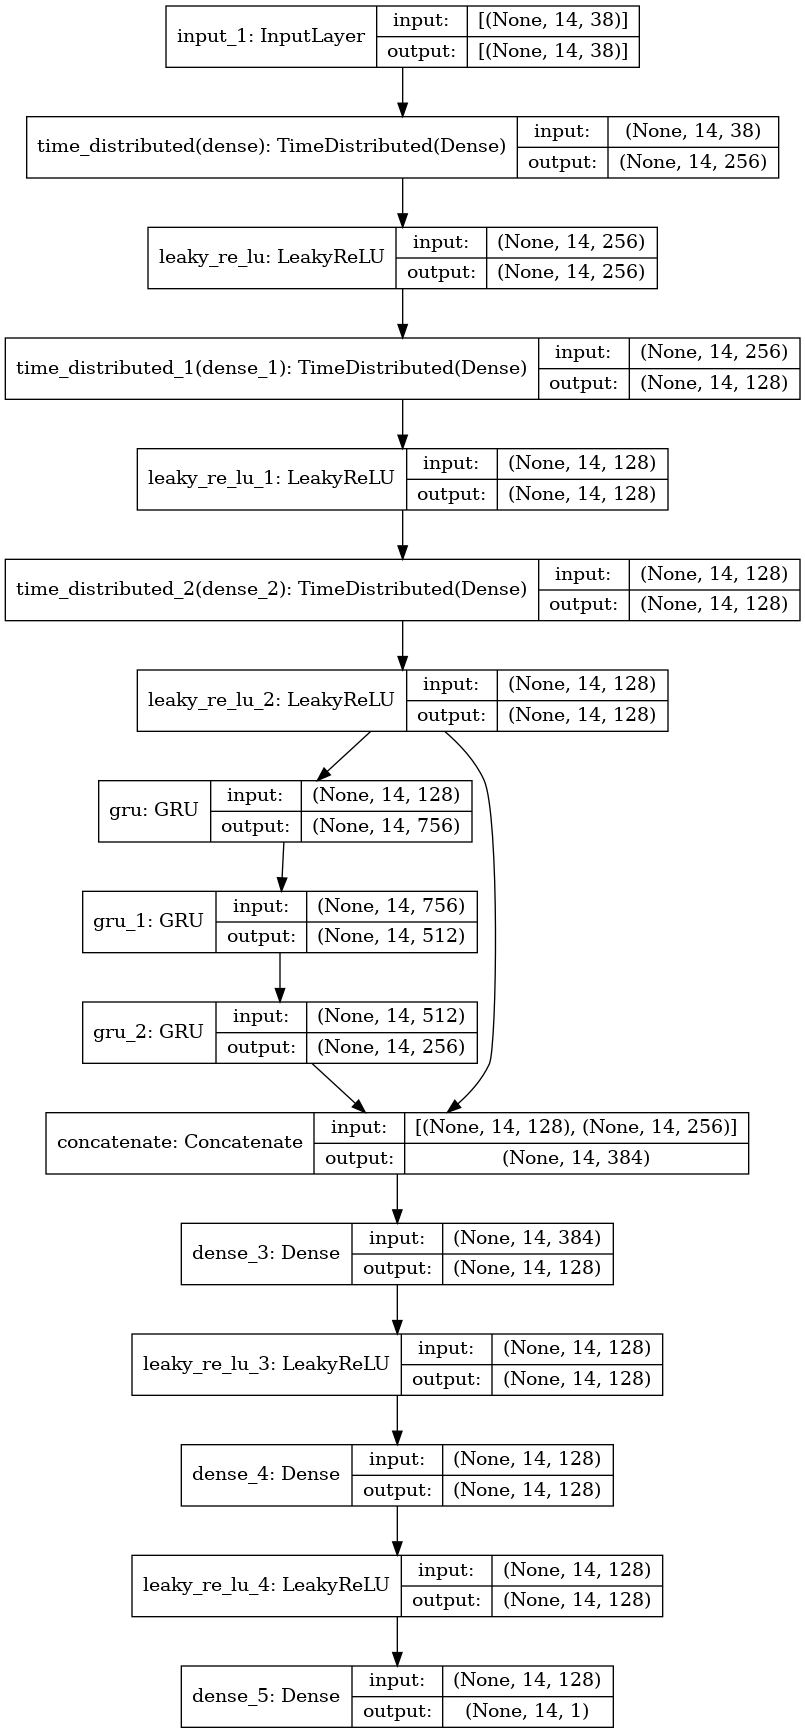

In [11]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)

In [12]:
device = tf.test.gpu_device_name()
device

2022-01-02 04:55:44.988822: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'/device:GPU:0'

2022-01-02 04:55:44.989163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 04:55:44.989573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-02 04:55:44.989675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-02 04:55:44.989742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-02 04:55:44.989766: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-01-02 04:55:44.989793: I tensorflow/stream_executor

In [13]:
def optimizer():
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    return optimizer

def loss_object():
    loss_object = tf.keras.losses.MeanAbsoluteError(name='mae')
    return loss_object

def train_rmse_metric():
    train_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    return train_rmse_metric


def valid_rmse_metric():
    valid_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    return valid_rmse_metric

In [14]:
optimizer = optimizer()
loss_object = loss_object()
train_rmse_metric = train_rmse_metric()
valid_rmse_metric = valid_rmse_metric()

In [16]:
@tf.function
def train_step(x, y):
    with tf.device(device_name=device):
        with tf.GradientTape() as tape:
            preds = model(x)
            loss_value = loss_object(y_true=y, y_pred=preds)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_rmse_metric.update_state(y, preds)
    return loss_value

In [18]:
@tf.function
def validation_step(x, y):
    with tf.device(device_name=device):
        preds = model(x)
        loss_value = loss_object(y, preds)
        valid_rmse_metric.update_state(y, preds)
    return loss_value

In [21]:
import time
from tqdm import tqdm

for epoch in range(2):
    print(f"Start of epoch {epoch+1}")
    start_time = time.time()
    train_loss_value = 0
    for step, (x_batch_train, y_batch_train) in tqdm(enumerate(train_ds)):
        train_loss_value += train_step(x_batch_train, y_batch_train)
        
    train_loss_value_mean = train_loss_value/len(train_ds)
    print(f"Train loss = {train_loss_value_mean}, Train RMSE = {train_rmse_metric.result()}")
    train_rmse_metric.reset_states()
    
    valid_loss_value = 0
    for step, (x_batch_valid, y_batch_valid) in enumerate(valid_ds):
        valid_loss_value += validation_step(x_batch_valid, y_batch_valid)
        
    valid_loss_value_mean =  valid_loss_value/len(valid_ds)
    print(f"Valid loss = {valid_loss_value_mean}, Valid RMSE = {valid_rmse_metric.result()}")
    valid_rmse_metric.reset_states()
    print(f"Time taken = {time.time() - start_time}")

Start of epoch 1


3719it [02:20, 26.52it/s]


Train loss = 0.13697698712348938, Train RMSE = 2.8852930068969727
Valid loss = 0.08206836134195328, Valid RMSE = 0.14890842139720917
Time taken = 143.08132982254028
Start of epoch 2


3719it [02:20, 26.51it/s]


Train loss = 0.008218346163630486, Train RMSE = 0.04017108678817749
Valid loss = 0.002124212682247162, Valid RMSE = 0.0035611267667263746
Time taken = 143.14846444129944
